In [30]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]


In [33]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

In [34]:
df = load_data_prep()

In [35]:
# Variable a predecir
target = 'label'

# Construcción de la matriz de features
X = df.drop(['cod', 'label'], axis=1)

# Construcción del vector a predecir
y = df[target].values

print('Dimensión de la matriz de features: {}'.format(X.shape))
print('Dimensión del vector a predecir: {}'.format(y.shape))
print('Vector a predecir: {}'.format(y))

Dimensión de la matriz de features: (67, 290)
Dimensión del vector a predecir: (67,)
Vector a predecir: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [36]:
# Solo por esta vez para a fijar la semilla de numeros aleatorios
# para que se separe siempre igual cada vez que corramos esta notebook 
random_seed = 123475

# Creacion de las matrices de entrenamiento y testeo. Aca fijamos la semilla para que siempre separe igual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = random_seed)

print('Dimensión de la matriz de features para entrenamiento: {}'.format(X_train.shape))
print('Dimensión de la matriz de features para testeo: {}'.format(X_test.shape))

Dimensión de la matriz de features para entrenamiento: (60, 290)
Dimensión de la matriz de features para testeo: (7, 290)


## 

In [37]:

std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

# Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)

In [38]:
from sklearn import model_selection
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_scaled,y_train)
# predictions
rfc_predict = rfc.predict(X_test_scaled)

In [39]:
## Corremos el modelo con cross validation
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6891666666666667


In [44]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_scaled, y_train)
# print results
print(rfc_random.best_params_)

{'n_estimators': 800, 'max_features': 'sqrt', 'max_depth': 220}


In [45]:
rfc = RandomForestClassifier(n_estimators=800, max_depth=220, max_features='sqrt') 
rfc.fit(X_scaled,y_train) 
rfc_predict = rfc.predict(X_test_scaled) 
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
print("=== Matriz de confusión ===") 
print(confusion_matrix(y_test, rfc_predict)) 
print('\n')
print("=== Informe de clasificación ===") 
print(classification_report(y_test, rfc_predict)) 
print('\n')
print("=== Todas las puntuaciones de AUC ===")
print(rfc_cv_score) 
print ('\n')
print("=== Puntuación AUC media ===") 
print("Puntuación AUC media - Random Forest: ", rfc_cv_score.mean())

=== Matriz de confusión ===
[[0 3]
 [0 4]]


=== Informe de clasificación ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.57      1.00      0.73         4

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7



=== Todas las puntuaciones de AUC ===
[0.8        0.8        0.75       0.58333333 0.58333333 0.25
 1.         0.75       0.625      0.75      ]


=== Puntuación AUC media ===
Puntuación AUC media - Random Forest:  0.6891666666666667


c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [ ]:
# Number of samples
N = len(y_pred)

# Compute the binary cross-entropy loss
binary_cross_entropy_loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Average the loss over all samples
average_loss = np.mean(binary_cross_entropy_loss)

In [47]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_scaled, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 18,
 'min_samples_leaf': 7,
 'max_features': 'sqrt',
 'max_depth': 7,
 'bootstrap': False}

In [48]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,18,7,sqrt,7,False,0.666667,1
1,1000,7,12,sqrt,2,True,0.650000,2
2,100,18,12,sqrt,1,False,0.650000,2
3,700,12,2,sqrt,13,False,0.650000,2
4,700,23,12,sqrt,8,True,0.650000,2
5,100,34,28,sqrt,2,True,0.633333,6
6,600,2,34,sqrt,12,True,0.633333,6
7,300,28,39,log2,14,True,0.633333,6
8,100,18,44,sqrt,8,False,0.633333,6
9,500,12,18,sqrt,13,False,0.633333,6


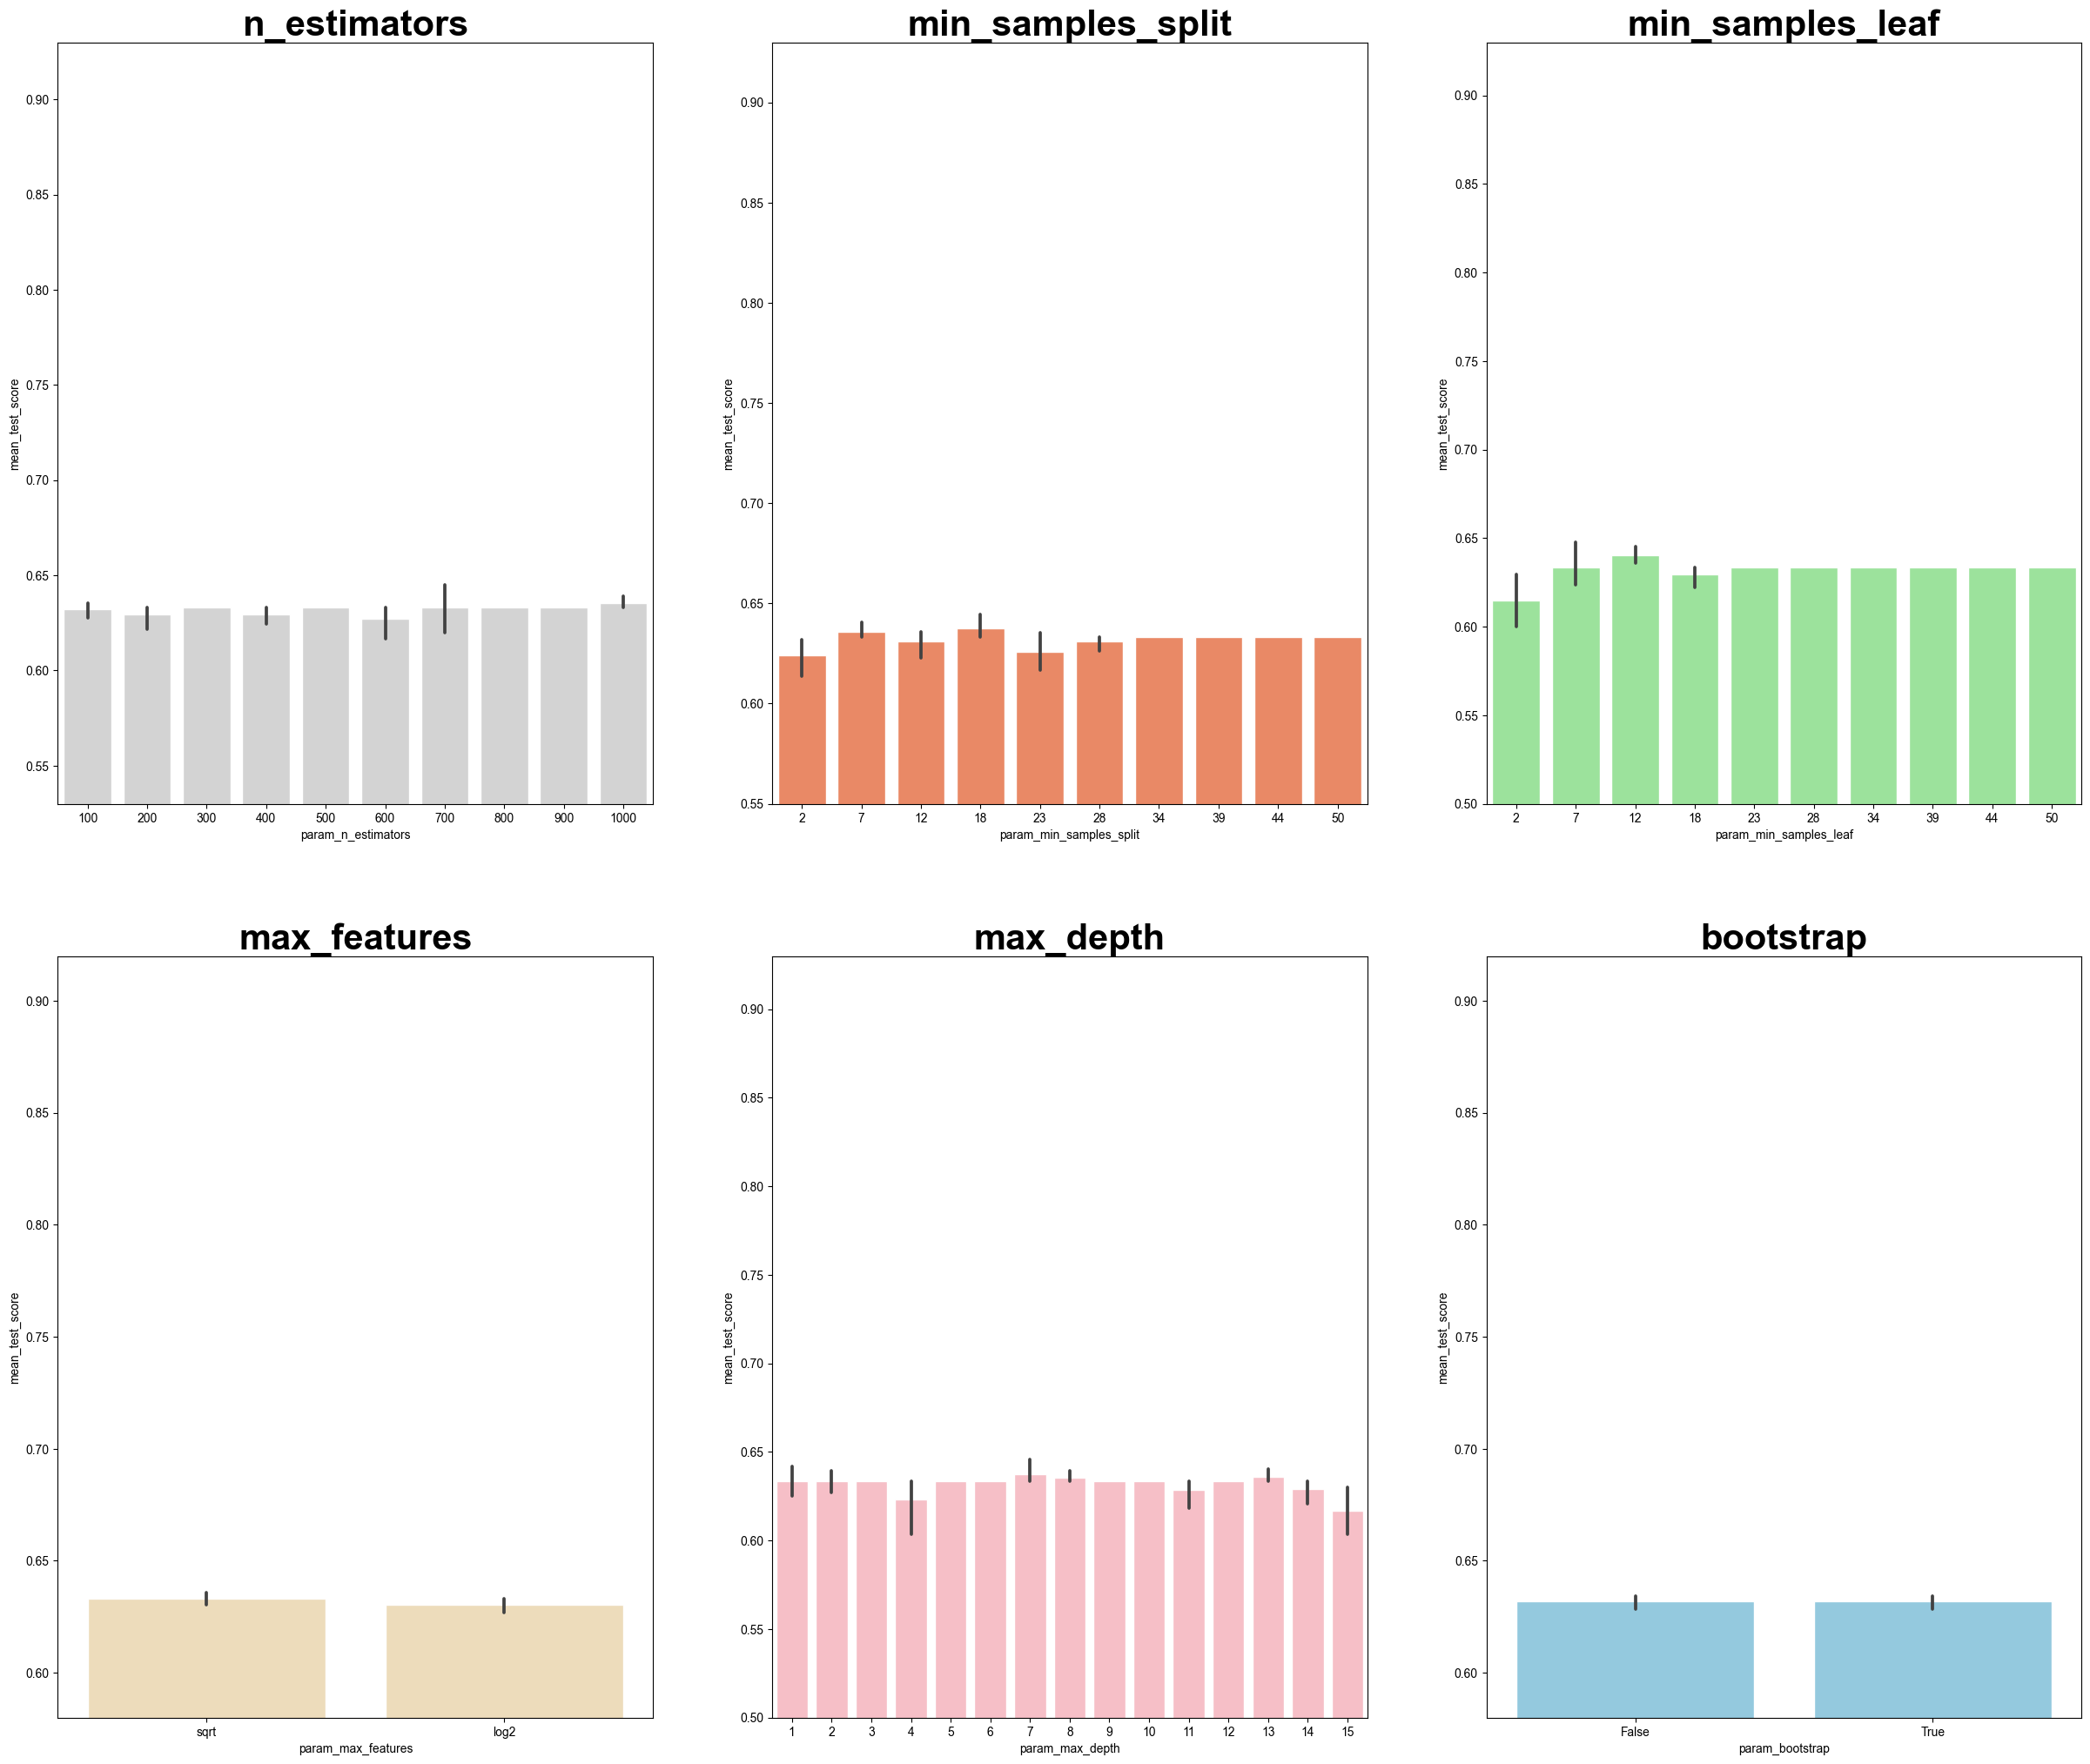

In [50]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.53,.93]), axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.55,.93]), axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.50,.93]), axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.58,.92]), axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.50,.93]), axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.58,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [51]:
from sklearn.model_selection import GridSearchCV
n_estimators = [400,700,1000]
max_features = ['sqrt']
max_depth = [1,7,8,11,13]
min_samples_split = [7,12,18,23,28]
min_samples_leaf = [2,7,12,18]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_scaled, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 300 candidates, totalling 900 fits


{'bootstrap': False,
 'max_depth': 1,
 'max_features': 'sqrt',
 'min_samples_leaf': 12,
 'min_samples_split': 7,
 'n_estimators': 400}

In [52]:
y_pred_gs = gs.best_estimator_.predict(X_scaled)

In [53]:
# veamos que tan bien le fue a este modelo
y_test = y_test.astype(y_train.dtype)
print(classification_report(y_true=y_test,y_pred=gs.best_estimator_.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.57      1.00      0.73         4

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7



c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le